In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression, GBTRegressor 
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


spark = (
    SparkSession.builder
    .appName("UnemploymentPrediction")
    .config("spark.driver.memory", "4g")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.ui.port", "4050")
    .getOrCreate()
)

print("Spark Session successfully started.")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/08 01:15:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session successfully started.


In [3]:
parquet_path = '../data_bls/integrated_bls_oews_state_year_occ_ecicpi.parquet'

df_spark = spark.read.parquet(parquet_path)

print(f"Total records loaded: {df_spark.count()}")
df_spark.printSchema()
df_spark.show(5, truncate=False)

# keep label the same unless you've renamed it
df_spark = df_spark.withColumn("label", df_spark["State_Unemployment_Rate"].cast("double"))
df_spark = df_spark.drop("State_Unemployment_Rate")


Total records loaded: 312596
root
 |-- Year: long (nullable = true)
 |-- State_FIPS: string (nullable = true)
 |-- Total_Labor_Force: long (nullable = true)
 |-- Total_Employed: long (nullable = true)
 |-- Total_Unemployed: long (nullable = true)
 |-- State_Unemployment_Rate: double (nullable = true)
 |-- OCC_CODE: string (nullable = true)
 |-- OCC_TITLE: string (nullable = true)
 |-- TOT_EMP: double (nullable = true)
 |-- A_MEAN: double (nullable = true)
 |-- A_MEDIAN: double (nullable = true)
 |-- A_PCT10: double (nullable = true)
 |-- A_PCT90: double (nullable = true)
 |-- eci_pct_change: double (nullable = true)
 |-- cpi_inflation_pct: double (nullable = true)
 |-- real_wage_growth: double (nullable = true)

+----+----------+-----------------+--------------+----------------+-----------------------+--------+-----------------------------------+-------+--------+--------+--------+-------+--------------+-----------------+----------------+
|Year|State_FIPS|Total_Labor_Force|Total_Employe

In [4]:
# Load ACS PUMS data
acs_parquet_path = '../data/processed/parquet_pums/pums_all_cleaned.parquet'

acs = spark.read.parquet(acs_parquet_path)

print(f"Total ACS PUMS records loaded: {acs.count()}")
print("\nACS PUMS Schema:")
acs.printSchema()
print("\nSample ACS PUMS rows:")
acs.select("ST", "YEAR", "AGEP", "SCHL", "ESR", "DIS", "WAGP").show(10, truncate=False)



Total ACS PUMS records loaded: 18600624

ACS PUMS Schema:
root
 |-- ST: integer (nullable = true)
 |-- PUMA: integer (nullable = true)
 |-- AGEP: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- RAC1P: integer (nullable = true)
 |-- HISP: integer (nullable = true)
 |-- MAR: integer (nullable = true)
 |-- SCHL: integer (nullable = true)
 |-- ESR: integer (nullable = true)
 |-- OCCP: integer (nullable = true)
 |-- SOCP: string (nullable = true)
 |-- WAGP: integer (nullable = true)
 |-- PINCP: integer (nullable = true)
 |-- WKW: integer (nullable = true)
 |-- DIS: integer (nullable = true)
 |-- DEAR: integer (nullable = true)
 |-- DEYE: integer (nullable = true)
 |-- DOUT: integer (nullable = true)
 |-- CIT: integer (nullable = true)
 |-- NATIVITY: integer (nullable = true)
 |-- YEAR: integer (nullable = true)


Sample ACS PUMS rows:
+---+----+----+----+---+---+-----+
|ST |YEAR|AGEP|SCHL|ESR|DIS|WAGP |
+---+----+----+----+---+---+-----+
|1  |2022|85  |19  |6  |1  |0    |

In [5]:
# Aggregate ACS PUMS to state-year level
# Create State_FIPS by left-padding ST to 2 digits as string (1 -> "01")
acs = acs.withColumn("State_FIPS", F.lpad(F.col("ST").cast("string"), 2, "0"))

# Aggregate by YEAR and State_FIPS
# Note: SCHL >= 21 means Bachelor's degree or higher
# ESR in {1,2,3,4,5} means in labor force; ESR 3 means unemployed
acs_state_year = acs.groupBy("YEAR", "State_FIPS").agg(
    F.count("*").alias("acs_population"),
    F.avg("AGEP").alias("acs_mean_age"),
    F.expr("percentile_approx(AGEP, 0.5)").alias("acs_median_age"),
    F.avg((F.col("SCHL") >= 21).cast("int")).alias("acs_share_bach_plus"),
    F.avg((F.col("DIS") == 1).cast("int")).alias("acs_share_disabled"),
    F.avg(F.col("ESR").isin([1, 2, 3, 4, 5]).cast("int")).alias("acs_labor_force_rate"),
    F.avg((F.col("ESR") == 3).cast("int")).alias("acs_unemp_rate_pums"),
    F.avg("WAGP").alias("acs_mean_wage"),
    F.expr("percentile_approx(WAGP, 0.5)").alias("acs_median_wage")
)

# Rename YEAR to Year to match df_spark
acs_state_year = acs_state_year.withColumnRenamed("YEAR", "Year")

print(f"\nACS state-year aggregates count: {acs_state_year.count()}")
print("\nACS state-year schema:")
acs_state_year.printSchema()
print("\nSample ACS state-year aggregates:")
acs_state_year.show(10, truncate=False)




ACS state-year aggregates count: 357

ACS state-year schema:
root
 |-- Year: integer (nullable = true)
 |-- State_FIPS: string (nullable = true)
 |-- acs_population: long (nullable = false)
 |-- acs_mean_age: double (nullable = true)
 |-- acs_median_age: integer (nullable = true)
 |-- acs_share_bach_plus: double (nullable = true)
 |-- acs_share_disabled: double (nullable = true)
 |-- acs_labor_force_rate: double (nullable = true)
 |-- acs_unemp_rate_pums: double (nullable = true)
 |-- acs_mean_wage: double (nullable = true)
 |-- acs_median_wage: integer (nullable = true)


Sample ACS state-year aggregates:


+----+----------+--------------+------------------+--------------+-------------------+-------------------+--------------------+--------------------+------------------+---------------+
|Year|State_FIPS|acs_population|acs_mean_age      |acs_median_age|acs_share_bach_plus|acs_share_disabled |acs_labor_force_rate|acs_unemp_rate_pums |acs_mean_wage     |acs_median_wage|
+----+----------+--------------+------------------+--------------+-------------------+-------------------+--------------------+--------------------+------------------+---------------+
|2022|27        |48299         |50.76630986148781 |52            |0.30801879956106754|0.1650137684010021 |0.6170521128801838  |0.01855110871860701 |35086.27176546098 |12300          |
|2022|18        |57189         |49.2179614960919  |50            |0.25719981115249435|0.1902813478116421 |0.597894700029726   |0.01911206700589274 |30523.902918393396|11100          |
|2022|13        |90442         |48.9895513146547  |50            |0.322361292319

In [6]:
# Join ACS aggregates into the main BLS/OEWS DataFrame
# Left join to keep all existing rows from df_spark
df_spark = df_spark.join(acs_state_year, on=["Year", "State_FIPS"], how="left")

print(f"\nAfter join - Total records: {df_spark.count()}")
print("\nUpdated schema with ACS features:")
df_spark.printSchema()

print("\nSample rows with ACS features:")
df_spark.select(
    "Year", "State_FIPS", "label", 
    "acs_population", "acs_mean_age", "acs_share_bach_plus", "acs_unemp_rate_pums"
).show(10, truncate=False)




After join - Total records: 312596

Updated schema with ACS features:
root
 |-- Year: long (nullable = true)
 |-- State_FIPS: string (nullable = true)
 |-- Total_Labor_Force: long (nullable = true)
 |-- Total_Employed: long (nullable = true)
 |-- Total_Unemployed: long (nullable = true)
 |-- OCC_CODE: string (nullable = true)
 |-- OCC_TITLE: string (nullable = true)
 |-- TOT_EMP: double (nullable = true)
 |-- A_MEAN: double (nullable = true)
 |-- A_MEDIAN: double (nullable = true)
 |-- A_PCT10: double (nullable = true)
 |-- A_PCT90: double (nullable = true)
 |-- eci_pct_change: double (nullable = true)
 |-- cpi_inflation_pct: double (nullable = true)
 |-- real_wage_growth: double (nullable = true)
 |-- label: double (nullable = true)
 |-- acs_population: long (nullable = true)
 |-- acs_mean_age: double (nullable = true)
 |-- acs_median_age: integer (nullable = true)
 |-- acs_share_bach_plus: double (nullable = true)
 |-- acs_share_disabled: double (nullable = true)
 |-- acs_labor_forc

+----+----------+----------------+--------------+-----------------+-------------------+-------------------+
|Year|State_FIPS|label           |acs_population|acs_mean_age     |acs_share_bach_plus|acs_unemp_rate_pums|
+----+----------+----------------+--------------+-----------------+-------------------+-------------------+
|2015|01        |6.10014917479779|39442         |49.71477105623447|0.2136808478271893 |0.03607829217585315|
|2015|01        |6.10014917479779|39442         |49.71477105623447|0.2136808478271893 |0.03607829217585315|
|2015|01        |6.10014917479779|39442         |49.71477105623447|0.2136808478271893 |0.03607829217585315|
|2015|01        |6.10014917479779|39442         |49.71477105623447|0.2136808478271893 |0.03607829217585315|
|2015|01        |6.10014917479779|39442         |49.71477105623447|0.2136808478271893 |0.03607829217585315|
|2015|01        |6.10014917479779|39442         |49.71477105623447|0.2136808478271893 |0.03607829217585315|
|2015|01        |6.100149174

In [7]:
df_spark.printSchema()
df_spark.show(5, truncate=False)
df_spark.columns
[col for col in df_spark.columns if "eci" in col.lower()]
[col for col in df_spark.columns if "cpi" in col.lower()]
[col for col in df_spark.columns if any(k in col.lower() for k in ["wage", "inflation", "real"])]


root
 |-- Year: long (nullable = true)
 |-- State_FIPS: string (nullable = true)
 |-- Total_Labor_Force: long (nullable = true)
 |-- Total_Employed: long (nullable = true)
 |-- Total_Unemployed: long (nullable = true)
 |-- OCC_CODE: string (nullable = true)
 |-- OCC_TITLE: string (nullable = true)
 |-- TOT_EMP: double (nullable = true)
 |-- A_MEAN: double (nullable = true)
 |-- A_MEDIAN: double (nullable = true)
 |-- A_PCT10: double (nullable = true)
 |-- A_PCT90: double (nullable = true)
 |-- eci_pct_change: double (nullable = true)
 |-- cpi_inflation_pct: double (nullable = true)
 |-- real_wage_growth: double (nullable = true)
 |-- label: double (nullable = true)
 |-- acs_population: long (nullable = true)
 |-- acs_mean_age: double (nullable = true)
 |-- acs_median_age: integer (nullable = true)
 |-- acs_share_bach_plus: double (nullable = true)
 |-- acs_share_disabled: double (nullable = true)
 |-- acs_labor_force_rate: double (nullable = true)
 |-- acs_unemp_rate_pums: double (null

+----+----------+-----------------+--------------+----------------+--------+-----------------------------------+-------+--------+--------+--------+-------+--------------+-----------------+----------------+----------------+--------------+-----------------+--------------+-------------------+-------------------+--------------------+-------------------+------------------+---------------+
|Year|State_FIPS|Total_Labor_Force|Total_Employed|Total_Unemployed|OCC_CODE|OCC_TITLE                          |TOT_EMP|A_MEAN  |A_MEDIAN|A_PCT10 |A_PCT90|eci_pct_change|cpi_inflation_pct|real_wage_growth|label           |acs_population|acs_mean_age     |acs_median_age|acs_share_bach_plus|acs_share_disabled |acs_labor_force_rate|acs_unemp_rate_pums|acs_mean_wage     |acs_median_wage|
+----+----------+-----------------+--------------+----------------+--------+-----------------------------------+-------+--------+--------+--------+-------+--------------+-----------------+----------------+----------------+----

['cpi_inflation_pct', 'real_wage_growth', 'acs_mean_wage', 'acs_median_wage']

In [8]:
# Fill missing values with median
# Original BLS/OEWS features
cols_to_fill = ["TOT_EMP", "A_MEAN", "A_MEDIAN", "A_PCT10", "A_PCT90", "eci_pct_change", "cpi_inflation_pct", "real_wage_growth"]

# ACS PUMS features to also fill
acs_cols_to_fill = [
    "acs_population", "acs_mean_age", "acs_median_age",
    "acs_share_bach_plus", "acs_share_disabled",
    "acs_labor_force_rate", "acs_unemp_rate_pums",
    "acs_mean_wage", "acs_median_wage"
]

# Combine all columns to fill
cols_to_fill = cols_to_fill + acs_cols_to_fill

for col in cols_to_fill:
    try:
        median_value = df_spark.approxQuantile(col, [0.5], 0.01)[0]
        df_spark = df_spark.fillna(median_value, subset=[col])
        print(f"Filled missing values in {col} with median: {median_value:.2f}")
    except Exception as e:
        print(f"Error calculating median for {col}: {e}. Skipping or check data quality.")



categorical_cols = ["State_FIPS", "OCC_CODE"]
indexed_cols = [col + "_Index" for col in categorical_cols]
encoded_cols = [col + "_Vec" for col in categorical_cols]


indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="keep") 
    for col in categorical_cols
]

# OneHotEncoder
encoders = [
    OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec")
    for col in categorical_cols
]

# Feature columns: original BLS/OEWS features + ACS PUMS features + encoded categoricals
feature_cols = [
    "Year", "Total_Labor_Force", "Total_Employed", "Total_Unemployed",
    "TOT_EMP", "A_MEAN", "A_MEDIAN", "A_PCT10", "A_PCT90", "eci_pct_change", 
    "cpi_inflation_pct", "real_wage_growth",
    # ACS PUMS features
    "acs_population", "acs_mean_age", "acs_median_age",
    "acs_share_bach_plus", "acs_share_disabled",
    "acs_labor_force_rate", "acs_unemp_rate_pums",
    "acs_mean_wage", "acs_median_wage"
] + encoded_cols

# Cast all scalar feature columns to double
for col in feature_cols:
    if col not in encoded_cols:
        df_spark = df_spark.withColumn(col, df_spark[col].cast("double"))

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# split test_trainiing data
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)
print(f"\nTraining records: {train_data.count()}, Test records: {test_data.count()}")

Filled missing values in TOT_EMP with median: 830.00


Filled missing values in A_MEAN with median: 50740.00


Filled missing values in A_MEDIAN with median: 47580.00


Filled missing values in A_PCT10 with median: 31300.00


Filled missing values in A_PCT90 with median: 71330.00


Filled missing values in eci_pct_change with median: 2.70


Filled missing values in cpi_inflation_pct with median: 2.20


Filled missing values in real_wage_growth with median: 0.40


Filled missing values in acs_population with median: 43288.00


Filled missing values in acs_mean_age with median: 49.35


Filled missing values in acs_median_age with median: 50.00


Filled missing values in acs_share_bach_plus with median: 0.28


Filled missing values in acs_share_disabled with median: 0.18


Filled missing values in acs_labor_force_rate with median: 0.60


Filled missing values in acs_unemp_rate_pums with median: 0.03


Filled missing values in acs_mean_wage with median: 28512.96


Filled missing values in acs_median_wage with median: 9000.00



Training records: 250382, Test records: 62214


# Train a Gradient-Boosted Trees (GBT) regression model:
GBT builds an ensemble of decision trees, where each new tree learns to correct the errors of the previous ones. It handles nonlinear relationships and complex feature interactions better than linear models.

The pipeline applies:
1. StringIndexer + OneHotEncoder for categorical variables (State_FIPS, OCC_CODE)
2. VectorAssembler to combine all numeric + encoded features
3. GBTRegressor to predict unemployment rate ("label")

- maxIter=15 and maxDepth=5 control model complexity; seed ensures reproducibility.
- The fitted pipeline is then used to generate predictions on the test dataset.


In [9]:
gbt = GBTRegressor(
    featuresCol="features", 
    labelCol="label", 
    maxIter=15,         
    maxDepth=5,          
    seed=42
)


pipeline = Pipeline(stages=indexers + encoders + [assembler, gbt])

print("\n--- Starting Model Training (GBT Regressor) ---")
gbt_model = pipeline.fit(train_data) 

print("Model training complete.")

predictions = gbt_model.transform(test_data)
predictions.select("label", "prediction").show(10)


--- Starting Model Training (GBT Regressor) ---


Model training complete.


25/12/08 01:36:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------+-----------------+
|            label|       prediction|
+-----------------+-----------------+
|4.819373539845981|5.509510382862651|
|4.819373539845981|5.509510382862651|
|4.819373539845981|5.509510382862651|
|4.819373539845981|5.509510382862651|
|4.819373539845981|5.509510382862651|
|4.819373539845981|5.509510382862651|
|4.819373539845981|5.509510382862651|
|4.819373539845981|5.509510382862651|
|4.819373539845981|5.509510382862651|
|4.819373539845981|5.509510382862651|
+-----------------+-----------------+
only showing top 10 rows



25/12/08 01:36:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


# Evaluate model performance after adding ACS PUMS features.
We compute two metrics:
1. R² (goodness of fit) – how much variance in unemployment the model explains
2. MAE (Mean Absolute Error) – average prediction error in percentage points

The code compares the new model performance against the baseline model
- baseline model only used BLS + OEWS + ECI + CPI features
- It reports whether ACS PUMS features improved prediction accuracy and calculates % improvement.

Evaluates whether the model meets project targets:
1. R² ≥ 0.85
2. MAE ≤ 0.005

In [10]:
# Evaluate model with ACS PUMS features
evaluator_r2 = RegressionEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="r2"
)
evaluator_mae = RegressionEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="mae"
)

# R-squared
r2 = evaluator_r2.evaluate(predictions)
print(f"\n--- Model Evaluation Results (WITH ACS PUMS Features) ---")
print(f"R-squared (R2): {r2:.4f}")

# MAE
mae = evaluator_mae.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Baseline performance (before adding ACS PUMS features)
baseline_r2 = 0.9181
baseline_mae = 0.3884

print(f"\n--- Comparison with Baseline (BEFORE ACS PUMS Features) ---")
print(f"Baseline R²: {baseline_r2:.4f} → New R²: {r2:.4f} (Change: {r2 - baseline_r2:+.4f})")
print(f"Baseline MAE: {baseline_mae:.4f} → New MAE: {mae:.4f} (Change: {mae - baseline_mae:+.4f})")

if mae < baseline_mae:
    improvement_pct = ((baseline_mae - mae) / baseline_mae) * 100
    print(f"\n✓ MAE improved by {improvement_pct:.2f}% with ACS PUMS features!")
else:
    print(f"\n⚠ MAE did not improve with ACS PUMS features.")

if r2 >= 0.85 and mae <= 0.005: 
    print("\n✓ Model meets project targets!")
else:
    print("\n⚠ Model still does NOT meet project targets (R2 >= 0.85, MAE <= 0.005).")
    print("Next step: Hyperparameter tuning (CrossValidator) or additional feature engineering.")




--- Model Evaluation Results (WITH ACS PUMS Features) ---
R-squared (R2): 0.9453


Mean Absolute Error (MAE): 0.2968

--- Comparison with Baseline (BEFORE ACS PUMS Features) ---
Baseline R²: 0.9181 → New R²: 0.9453 (Change: +0.0272)
Baseline MAE: 0.3884 → New MAE: 0.2968 (Change: -0.0916)

✓ MAE improved by 23.60% with ACS PUMS features!

⚠ Model still does NOT meet project targets (R2 >= 0.85, MAE <= 0.005).
Next step: Hyperparameter tuning (CrossValidator) or additional feature engineering.


# Visualization of model performance.

Visualization A: Predicted vs Actual
- Creates a scatter plot comparing true unemployment rates ("label") against the model's predictions.
- Points close to the red diagonal line indicate accurate predictions. This helps visually assess bias, underfitting, or overfitting.
- Points lie very close to the red “perfect fit” line, indicating strong predictive accuracy.
- The relationship is highly linear, consistent with the model’s R² of 0.9453.
- Predictions remain accurate even at higher unemployment rates.

# -------------------------------------------------------------

Visualization B: Residual Analysis
- Computes residuals (actual – predicted) and plots them against the predicted values. A good model produces residuals randomly scattered around zero, with no clear pattern. Patterns or funnel shapes would indicate heteroscedasticity or model bias.
- Residuals are centered around zero and the spread of residuals is fairly uniform, meaning there is no major bias or structural error.
- A slight increase in variance at higher unemployment rates suggests:

the model may find rare high-unemployment cases harder to predict

- These two visuals together show how well the model fits the data and whether prediction errors are systematic or random.



--- Visualization A: Predicted vs. Actual Values ---


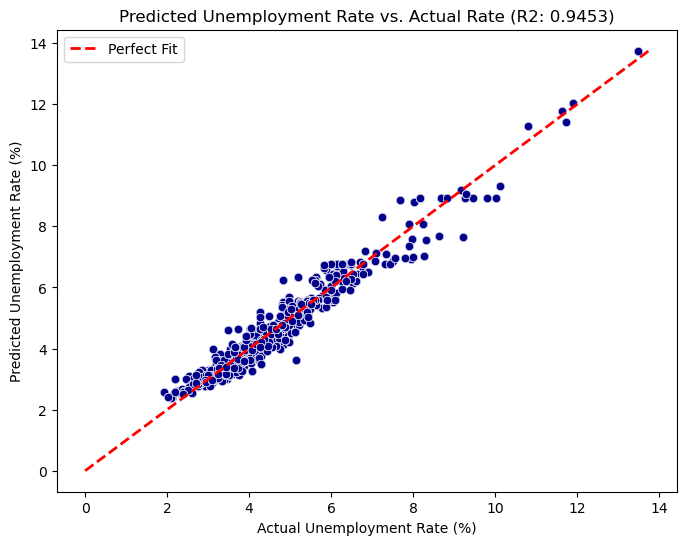


--- Visualization B: Residual Analysis ---


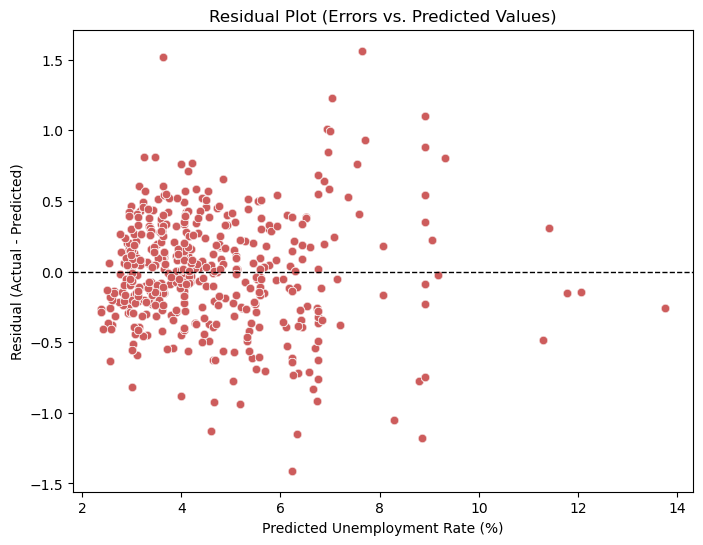

In [11]:

print("\n--- Visualization A: Predicted vs. Actual Values ---")

plot_data_spark = predictions.select("label", "prediction").sample(False, 0.1, seed=42)
plot_data_pd = plot_data_spark.toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='label', 
    y='prediction', 
    data=plot_data_pd, 
    alpha=0.6,
    color='darkblue'
)
max_val = max(plot_data_pd['label'].max(), plot_data_pd['prediction'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title(f'Predicted Unemployment Rate vs. Actual Rate (R2: {r2:.4f})')
plt.xlabel('Actual Unemployment Rate (%)')
plt.ylabel('Predicted Unemployment Rate (%)')
plt.legend()
plt.show()

print("\n--- Visualization B: Residual Analysis ---")

predictions_with_residuals = predictions.withColumn(
    "residual", 
    predictions["label"] - predictions["prediction"]
)

residual_plot_data_spark = predictions_with_residuals.select("prediction", "residual").sample(False, 0.1, seed=42)
residual_plot_data_pd = residual_plot_data_spark.toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='prediction', 
    y='residual', 
    data=residual_plot_data_pd, 
    alpha=0.6,
    color='indianred'
)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.title('Residual Plot (Errors vs. Predicted Values)')
plt.xlabel('Predicted Unemployment Rate (%)')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()

spark.stop()